In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import integrate, optimize, stats

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 3125
torch.set_default_dtype(torch.float)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

In [3]:


# Define PDFs
def bimodal_pdf_unnorm(x, A=1.0):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    return torch.exp(-1/A * (-x**2/2 + x**4/4))

def normal_pdf(x, sigma=1.0):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x, dtype=torch.float32)
    return (1 / (sigma * np.sqrt(2 * np.pi))) * torch.exp(-x**2/(2*sigma**2))

def compute_Z(A):
    integrand = lambda x: np.exp(-1/A * (-x**2/2 + x**4/4))
    result, _ = integrate.quad(integrand, -10, 10) 
    return result

def calculate_M(sigma, A, Z):
    x_vals = np.linspace(-10, 10, 10000)  
    bimodal_unnorm = np.exp(-1/A * (-x_vals**2/2 + x_vals**4/4))
    bimodal = bimodal_unnorm / Z
    normal = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-x_vals**2/(2*sigma**2))
    
    # Handle potential division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        ratios = np.where(normal > 1e-10, bimodal / normal, 0)
    
    return np.max(ratios) * 1.01  # Add 1% safety margin

def find_optimal_sigma(A, Z):

    def objective(sigma):
            return calculate_M(sigma[0], A, Z)
    
    bounds = [(0.1, 5.0)] 
    initial_guess = [1.0]
    
    result = optimize.minimize(
        objective, 
        initial_guess, 
        bounds=bounds,
        method='L-BFGS-B'
    )
    
    optimal_sigma = result.x[0]
    return optimal_sigma

In [6]:
def create_bimodal_samples_flat(batch_size = 4000, A=1.0):
    Z = compute_Z(A)
    sigma = find_optimal_sigma(A, Z)
    M = calculate_M(sigma, A, Z)

    num_samples = batch_size
    
    # Initialize storage for accepted samples
    accepted_samples = torch.zeros(num_samples, 1).to(device)
    accepted_count = 0
    total_iterations = 0
    max_iterations = 1000000  # Prevent infinite loops
    
    # Start timing
    start_time = time.time()
    
    # Main acceptance-rejection loop
    while accepted_count < num_samples and total_iterations < max_iterations:
        # Generate proposal samples from normal distribution
        proposal_batch_size = min(batch_size, num_samples - accepted_count)
        normal_samples = np.random.normal(0, sigma, size=proposal_batch_size).astype(np.float32)
        proposal_samples = torch.tensor(normal_samples).unsqueeze(1).to(device)
        
        # Generate uniform samples for acceptance test
        uni_acceptance = np.random.uniform(low=0, high=1, size=proposal_batch_size).astype(np.float32)
        uni_acceptance = torch.tensor(uni_acceptance).unsqueeze(1).to(device)
        
        # Compute bimodal density of proposal
        bimodal_density = bimodal_pdf_unnorm(proposal_samples, A=A) / Z
        
        # Compute proposal density
        prop_density = normal_pdf(proposal_samples, sigma=sigma)
        
        # Compute acceptance probability
        acceptance_ratio = bimodal_density / (M * prop_density)
        
        # Accept samples where uni_acceptance <= acceptance_ratio
        accept_mask = (uni_acceptance <= acceptance_ratio).squeeze()
        
        if accept_mask.sum() > 0:
            num_accepted_batch = min(accept_mask.sum().item(), num_samples - accepted_count)
            accepted_samples[accepted_count:accepted_count + num_accepted_batch] = \
                proposal_samples[accept_mask][:num_accepted_batch]
            accepted_count += num_accepted_batch
        
        total_iterations += proposal_batch_size
        
        if total_iterations % 10000 == 0:
            print(f'Iterations: {total_iterations}, Accepted: {accepted_count}/{num_samples}, ' 
                  f'Efficiency: {100 * accepted_count / total_iterations:.2f}%')
    
    elapsed_time = time.time() - start_time
    efficiency = 100 * accepted_count / total_iterations
    
    print(f"Bimodal sampling completed in {elapsed_time:.2f} seconds.")
    print(f"Generated {accepted_count} samples from {total_iterations} proposal samples.")
    print(f"Acceptance efficiency: {efficiency:.2f}%")
    print(f"Theoretical acceptance rate: {100/M:.2f}%")
    
    bimodal_samples = accepted_samples.cpu().numpy()
    return bimodal_samples.flatten()

Bimodal sampling completed in 0.02 seconds.
Generated 4000 samples from 6374 proposal samples.
Acceptance efficiency: 62.75%
Theoretical acceptance rate: 63.02%


Text(0, 0.5, 'Density')

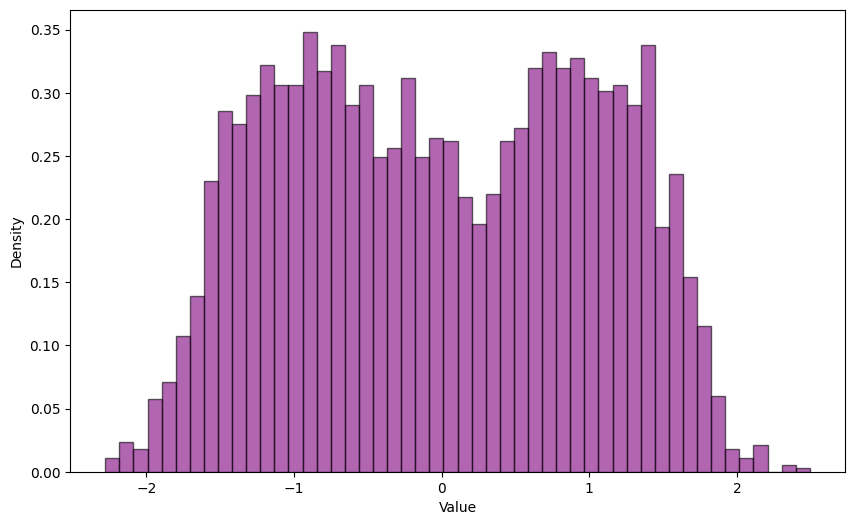

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(create_bimodal_samples_flat(), bins=50, density=True, alpha=0.6, color='purple', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Density')

In [8]:
# Define the neural network
class FNN(nn.Module):
    def __init__(self):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(1, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

In [9]:
# Improved KDE-based PDF loss function
class PDFLoss(nn.Module):
    def __init__(self, target_tensor, bw=0.1, min_val=-5, max_val=5, n_bins=100):
        super(PDFLoss, self).__init__()
        self.bw = bw
        self.min_val = min_val
        self.max_val = max_val
        self.n_bins = n_bins
        
        # Create evaluation points
        self.eval_points = torch.linspace(min_val, max_val, n_bins).to(device)
        
        # Precompute target KDE
        target_flat = target_tensor.view(-1)
        self.target_density = self._kde(target_flat, self.eval_points)
    
    def _kde(self, samples, eval_points):
        """Kernel Density Estimation with Gaussian kernel"""
        samples = samples.view(-1, 1)
        eval_points = eval_points.view(-1, 1)
        
        # Calculate pairwise distances
        dist = eval_points - samples.t()
        
        # Apply Gaussian kernel
        weights = torch.exp(-0.5 * (dist / self.bw)**2) / (self.bw * np.sqrt(2 * np.pi))
        
        # Average over samples
        density = weights.mean(dim=1)
        return density
    
    def forward(self, pred_samples):
        """Calculate L2 loss between predicted and target densities"""
        pred_flat = pred_samples.view(-1)
        pred_density = self._kde(pred_flat, self.eval_points)
        
        # Return L2 loss
        return torch.mean((pred_density - self.target_density)**2)

In [10]:
# Generate sample data
batch_size = 4000

# Generate uniform samples
uniform_samples = np.random.uniform(low=0, high=1, size=batch_size).astype(np.float32)

# Generate bimodal samples
bimodal_samples = create_bimodal_samples_flat(batch_size)

# Convert to tensors
uni_input = torch.from_numpy(uniform_samples.reshape(batch_size, 1)).to(device)
target = torch.from_numpy(bimodal_samples.reshape(batch_size, 1)).to(device)

Bimodal sampling completed in 0.01 seconds.
Generated 4000 samples from 6306 proposal samples.
Acceptance efficiency: 63.43%
Theoretical acceptance rate: 63.02%


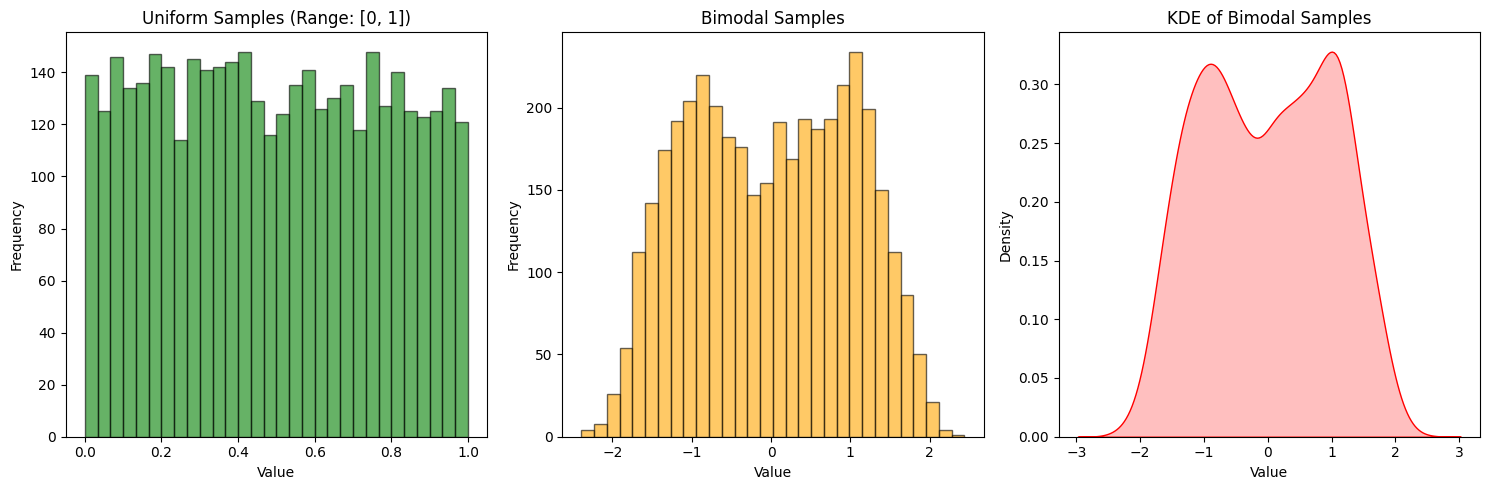

In [11]:
# Visualize input and target distributions
plt.figure(figsize=(15, 5))

# Plot uniform distribution
plt.subplot(1, 3, 1)
plt.hist(uniform_samples, bins=30, alpha=0.6, color='green', edgecolor='black')
plt.title('Uniform Samples (Range: [0, 1])')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot bimodal distribution
plt.subplot(1, 3, 2)
plt.hist(bimodal_samples, bins=30, alpha=0.6, color='orange', edgecolor='black')
plt.title('Bimodal Samples')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Plot density
plt.subplot(1, 3, 3)
sns.kdeplot(bimodal_samples, color='red', fill=True)
plt.title('KDE of Bimodal Samples')
plt.xlabel('Value')
plt.tight_layout()
plt.show()

In [12]:
# Create custom loss function
loss_function = PDFLoss(target, bw=0.2, min_val=-3, max_val=3, n_bins=200)

# Initialize the neural network
model = FNN().to(device)

# Define optimizer - using a slightly lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize lists to store loss over epochs
loss_list = []
epoch_list = []

In [13]:
# Training loop
num_epochs = 20000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(uni_input)
    
    # Compute loss
    loss = loss_function(outputs)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Store loss and epoch number
    loss_list.append(loss.item())
    epoch_list.append(epoch + 1)
    
    # Logging every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.8f}')
    
    # Early stopping condition
    if loss.item() <= 0.000005:
        print(f"Early stopping at epoch {epoch+1} with loss {loss.item():.8f}")
        break

Epoch [100/20000], Loss: 0.00049900
Epoch [200/20000], Loss: 0.00044756
Epoch [300/20000], Loss: 0.00042018
Epoch [400/20000], Loss: 0.00040032
Epoch [500/20000], Loss: 0.00038670
Epoch [600/20000], Loss: 0.00037855
Epoch [700/20000], Loss: 0.00037434
Epoch [800/20000], Loss: 0.00037180
Epoch [900/20000], Loss: 0.00036831
Epoch [1000/20000], Loss: 0.00035255
Epoch [1100/20000], Loss: 0.00028207
Epoch [1200/20000], Loss: 0.00020633
Epoch [1300/20000], Loss: 0.00018130
Epoch [1400/20000], Loss: 0.00017346
Epoch [1500/20000], Loss: 0.00016510
Epoch [1600/20000], Loss: 0.00015552
Epoch [1700/20000], Loss: 0.00013927
Epoch [1800/20000], Loss: 0.00011517
Epoch [1900/20000], Loss: 0.00009138
Epoch [2000/20000], Loss: 0.00006775
Epoch [2100/20000], Loss: 0.00005234
Epoch [2200/20000], Loss: 0.00003944
Epoch [2300/20000], Loss: 0.00003178
Epoch [2400/20000], Loss: 0.00002413
Epoch [2500/20000], Loss: 0.00002051
Epoch [2600/20000], Loss: 0.00001888
Epoch [2700/20000], Loss: 0.00001749
Epoch [280

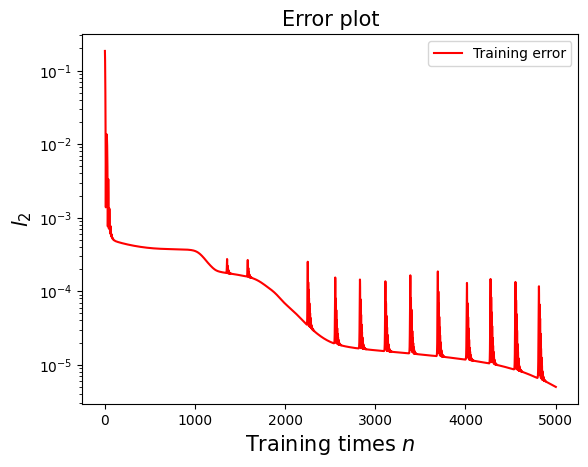

In [14]:
# Plot loss curve
plt.figure()
plt.title("Error plot", fontsize=15) 
plt.yscale('log')
plt.plot(epoch_list, loss_list, 'r', label='Training error')
plt.xlabel(r'Training times $n$', fontsize=15)
plt.ylabel(r'$l_2$', fontsize=15)
plt.legend()
plt.show()

In [17]:
# Test the transformation
np.random.seed(seed)
with torch.no_grad():
    # Generate new uniform samples for testing
    test_uniform = np.random.uniform(low=0, high=1, size=batch_size).astype(np.float32)
    test_input = torch.from_numpy(test_uniform.reshape(batch_size, 1)).to(device)
    
    # Transform samples using the trained model
    transformed_samples = model(test_input)

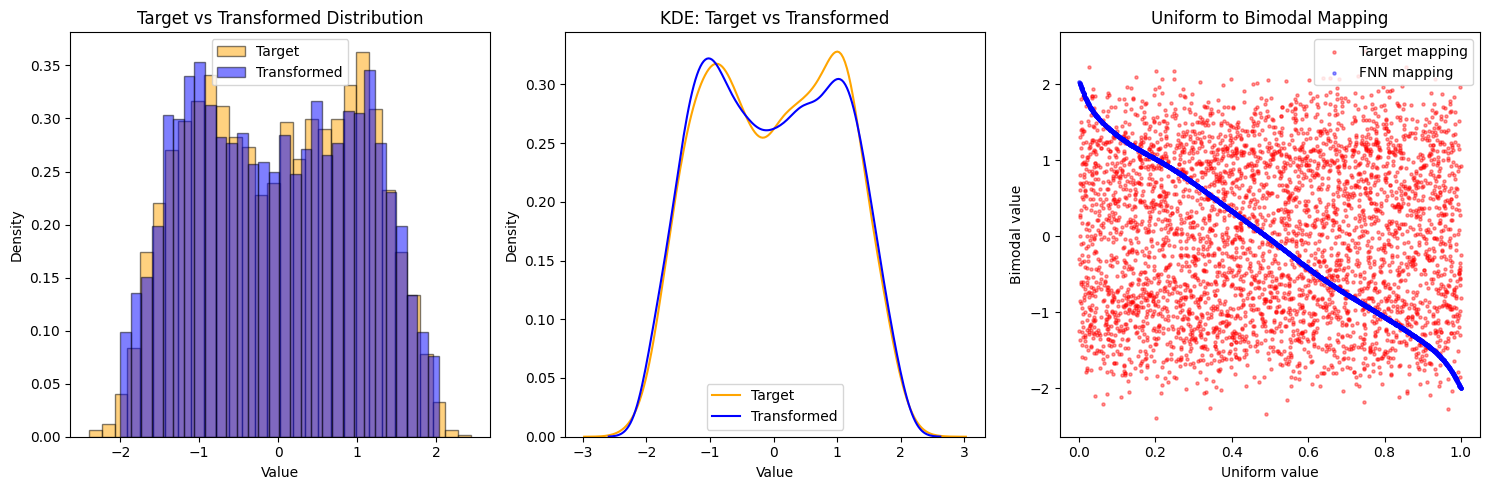

In [18]:
plt.figure(figsize=(15, 5))

# Histogram comparison
plt.subplot(1, 3, 1)
plt.hist(bimodal_samples, bins=30, alpha=0.5, density=True, color='orange', 
         edgecolor='black', label='Target')
plt.hist(transformed_samples.cpu().numpy().flatten(), bins=30, alpha=0.5, 
         density=True, color='blue', edgecolor='black', label='Transformed')
plt.title('Target vs Transformed Distribution')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# KDE comparison
plt.subplot(1, 3, 2)
sns.kdeplot(bimodal_samples, color='orange', label='Target')
sns.kdeplot(transformed_samples.cpu().numpy().flatten(), color='blue', label='Transformed')
plt.title('KDE: Target vs Transformed')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(uniform_samples, bimodal_samples, c='r', s=5, alpha=0.4, label='Target mapping')
plt.scatter(test_uniform, transformed_samples.cpu().numpy().flatten(), 
           c='b', s=5, alpha=0.4, label='FNN mapping')
plt.title('Uniform to Bimodal Mapping')
plt.xlabel('Uniform value')
plt.ylabel('Bimodal value')
plt.legend()

plt.tight_layout()
plt.show()